In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import scipy

import arviz as az

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer import NUTS, MCMC

az.style.use("arviz-darkgrid")


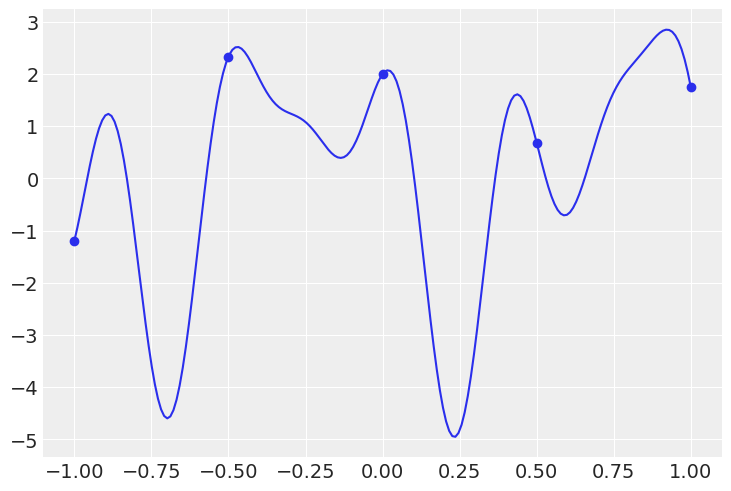

In [17]:
def f(x):
    return np.sin(20*x) + 2*np.cos(14*x) - 2*np.sin(6*x)

# dataset
X = torch.tensor([-1.0, -0.5, 0.0, 0.5, 1.0])
X_star = torch.linspace(-1, 1, 200)
y = f(X)
y_star = f(X_star)

plt.scatter(X, y)
plt.plot(X_star,y_star)

Sample: 100%|██████████| 1000/1000 [00:32, 30.56it/s, step size=6.24e-01, acc. prob=0.860]


array([<AxesSubplot:title={'center':'kernel.lengthscale'}>,
       <AxesSubplot:title={'center':'kernel.variance'}>], dtype=object)

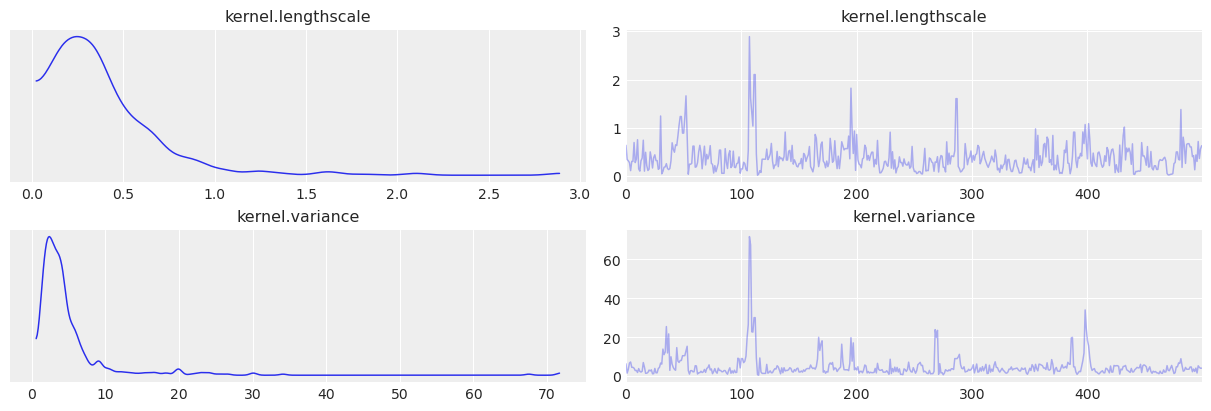

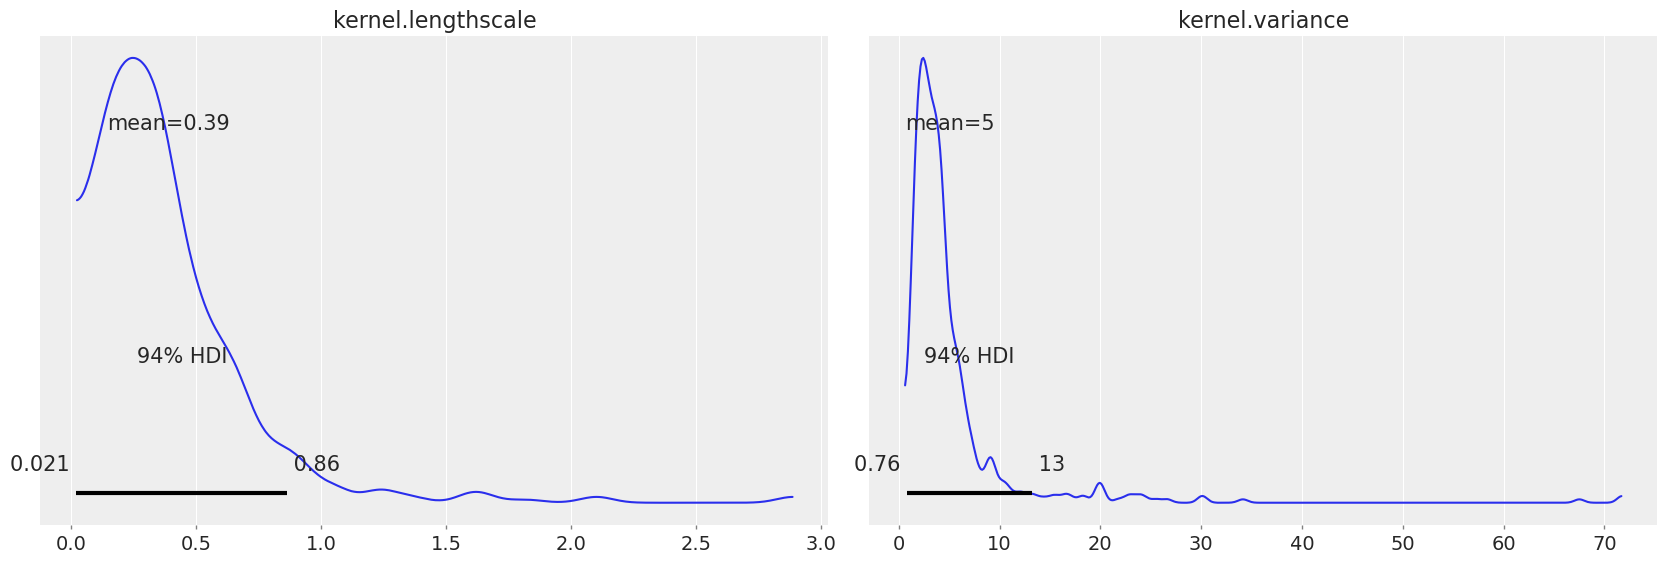

In [18]:
# trying with MCMC
pyro.clear_param_store()

no_samples = 500

# kernel = gp.kernels.RBF(input_dim=1)
kernel = gp.kernels.Matern32(input_dim=1)

kernel.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))

gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(10.0**(-4)))

nuts_kernel = NUTS(gpr.model)
mcmc = MCMC(nuts_kernel, num_samples=no_samples)
mcmc.run()

posterior_ls = mcmc.get_samples()["kernel.lengthscale"]
posterior_var = mcmc.get_samples()['kernel.variance']

az.plot_trace(mcmc.get_samples(),compact=False)
az.plot_posterior(mcmc.get_samples())

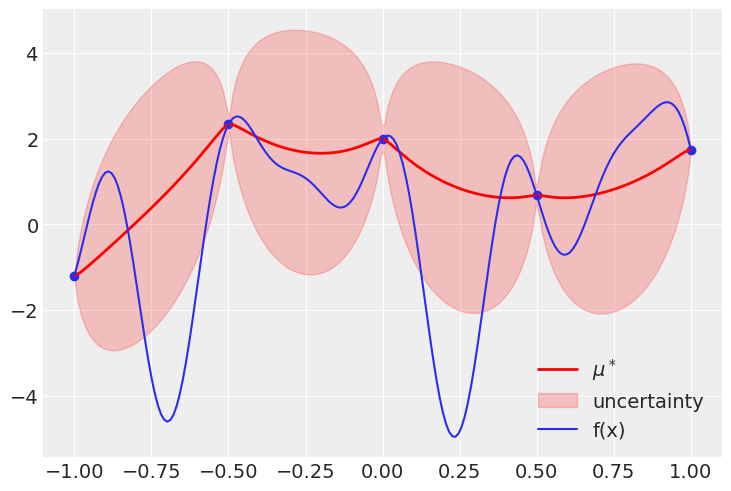

In [13]:
# compute predictive mean and variance at x_stars

means = torch.zeros(len(X_star), no_samples)
covs  = torch.zeros(len(X_star), len(X_star), no_samples)

for i in range(no_samples):
    with torch.no_grad():
        gpr.kernel.lengthscale = posterior_ls[i]
        gpr.kernel.variance = posterior_var[i]
        means[:, i], covs[:, :, i] = gpr(X_star, full_cov=True, noiseless=False)

mean_post = means.mean(axis=1) # Posterior mean
cov_post = covs.mean(axis=2) # Posterior variance

sd = cov_post.diag().sqrt()  # standard deviation at each input point x
plt.plot(X_star.numpy(), mean_post.numpy(), "r", lw=2, label=r'$\mu^*$')  # plot the mean
plt.fill_between(
    X_star,  # plot the two-sigma uncertainty about the mean
    (mean_post - 2.0 * sd).numpy(),
    (mean_post + 2.0 * sd).numpy(),
    color="r",
    alpha=0.2,
    label='uncertainty'
)
plt.plot(X_star, y_star, label='f(x)')
plt.scatter(X, y)
plt.legend()

### Bayesian Optimization

Found minimums, 10 reps: tensor([-4.9492, -4.5962, -4.5962, -4.9492, -4.9492, -4.9492, -4.9492, -4.9492,
        -4.7188, -4.9492])
Number of iterations to find min: tensor([16.,  0.,  0., 14.,  9.,  9., 14.,  3.,  0.,  8.])


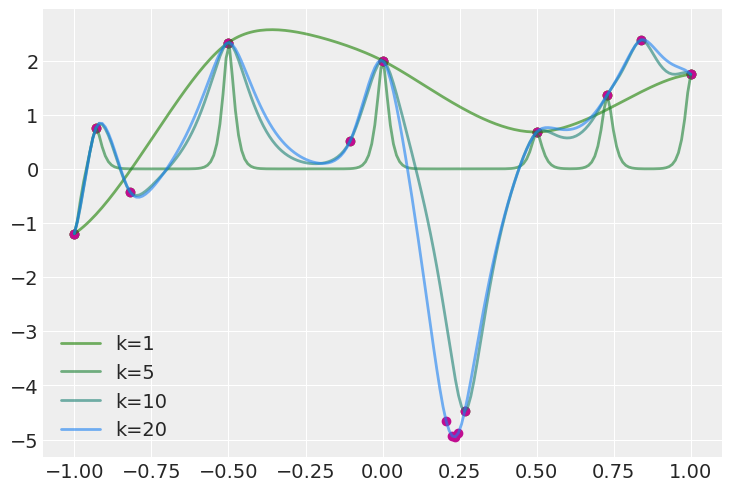

In [14]:
# Algorithm 1
torch.manual_seed(2005)
T = 20
n_reps = 10 # Number of repetitions to repeat Baeysian optimization algorithm
ks = (0, 4, 9, 19)

def Bayesian_optimization(X, y, X_star, y_star, T, print=False):
    
    no_iter = 0

    for k in range(T):

        pyro.clear_param_store()

        # kernel = gp.kernels.RBF(input_dim=1)
        kernel = gp.kernels.Matern32(input_dim=1)
        kernel.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
        kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))

        gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(10.0**(-4)))
        nuts_kernel = NUTS(gpr.model)
        mcmc = MCMC(nuts_kernel, num_samples=1, disable_progbar=True, warmup_steps=10)
        mcmc.run()
        gpr.kernel.lengthscale = mcmc.get_samples()["kernel.lengthscale"][0]
        gpr.kernel.variance = mcmc.get_samples()['kernel.variance'][0]
        
        with torch.no_grad():
            mean, cov = gpr(X_star, full_cov=True, noiseless=False)

        if k in ks and print==True:
            color = (0.1, 0.5, k / T)
            sd = cov.diag().sqrt()  # standard deviation at each input point x
            plt.plot(X_star.numpy(), mean.numpy(), lw=2, c=color, alpha=0.6, label=f'k={k+1}')  # plot the mean
            plt.scatter(X, y)
            plt.legend()

        # Draw from posterior
        try:
            f_star = torch.distributions.MultivariateNormal(mean, cov).sample()
        except ValueError: # if cov isn't positive definite
            continue

        # Find minimum and update
        idx_p = f_star.argmin()
        x_p = X_star[idx_p]
        f_x_p = f(x_p)

        if f_x_p == min(y_star) and f_x_p not in y:
            no_iter = k # Number of iterations till minimum is found

        if f_x_p not in y:
            x_p_idx = torch.searchsorted(X, x_p)
            X = torch.from_numpy(np.insert(X.numpy(), x_p_idx.numpy(), x_p.numpy()))
            y = torch.from_numpy(np.insert(y.numpy(), x_p_idx.numpy(), f_x_p))


    return min(y), no_iter

    
min_y = Bayesian_optimization(X, y, X_star, y_star, T, print=True)

min_ys = torch.zeros(n_reps)
no_iters = torch.zeros(n_reps)
for i in range(n_reps):
    min_ys[i], no_iters[i] = Bayesian_optimization(X, y, X_star, y_star, T, print=False)

print('Found minimums, 10 reps:', min_ys)
print('Number of iterations to find min:', no_iters)

GP-LCB

Found minimums, 10 reps: tensor([-4.9492, -4.9492, -4.9492, -4.9492, -4.9492, -4.9492, -4.9492, -4.9492,
        -4.9492, -4.9492])
Number of iterations to find min: tensor([ 8.,  9.,  5.,  9., 10.,  6.,  8.,  7.,  7.,  9.])


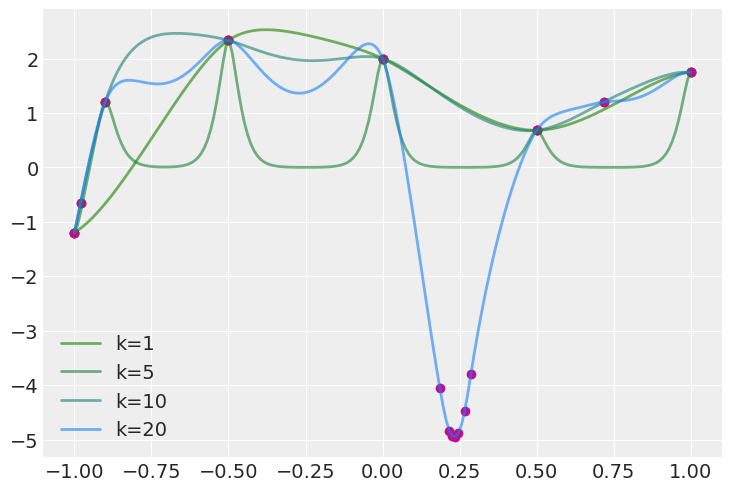

In [15]:
torch.manual_seed(2000)
T = 20
n_reps = 10 # Number of repetitions to repeat Baeysian optimization algorithm
ks = (0, 4, 9, 19)
kappa = torch.tensor(1.)

def GP_LCB(X, y, X_star, y_star, T, print=False):

    no_iter = 0 
    beta = torch.sqrt(kappa * torch.log((torch.arange(T) + 1)))

    for k in range(T):

        pyro.clear_param_store()
        # kernel = gp.kernels.RBF(input_dim=1)
        kernel = gp.kernels.Matern32(input_dim=1)
        kernel.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
        kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))

        gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(10.0**(-4)))
        nuts_kernel = NUTS(gpr.model)
        mcmc = MCMC(nuts_kernel, num_samples=1, disable_progbar=True, warmup_steps=10)
        try:
            mcmc.run()
        except:
            mcmc.run()

        gpr.kernel.lengthscale = mcmc.get_samples()["kernel.lengthscale"][0]
        gpr.kernel.variance = mcmc.get_samples()['kernel.variance'][0]
        
        with torch.no_grad():
            mean, cov = gpr(X_star, full_cov=True, noiseless=False)

        if k in ks and print==True:
            color = (0.1, 0.5, k / T)
            sd = cov.diag().sqrt()  # standard deviation at each input point x
            plt.plot(X_star.numpy(), mean.numpy(), lw=2, c=color, alpha=0.6, label=f'k={k+1}')  # plot the mean
            plt.scatter(X, y)
            plt.legend()

        # Use GP-LCB and update
        idx_p = (mean - beta[k] * cov.diag().sqrt()).argmin()
        x_p = X_star[idx_p]
        f_x_p = f(x_p)

        if f_x_p == min(y_star) and f_x_p not in y:
            no_iter = k # Number of iterations till minimum is found

        if f_x_p not in y:
            x_p_idx = torch.searchsorted(X, x_p)
            X = torch.from_numpy(np.insert(X.numpy(), x_p_idx.numpy(), x_p.numpy()))
            y = torch.from_numpy(np.insert(y.numpy(), x_p_idx.numpy(), f_x_p))

    return min(y), no_iter

    
min_y = GP_LCB(X, y, X_star, y_star, T, print=True)

min_ys = torch.zeros(n_reps)
no_iters = torch.zeros(n_reps)
for i in range(n_reps):
    min_ys[i], no_iters[i] = GP_LCB(X, y, X_star, y_star, T, print=False)

print('Found minimums, 10 reps:', min_ys)
print('Number of iterations to find min:', no_iters)

C:\Users\Juliu\AppData\Local\Temp\ipykernel_15860\4139916549.py:8: RuntimeWarning: invalid value encountered in log
  pdf = (np.exp(-(np.log(xx) - mu)**2 / (2 * sigma**2))


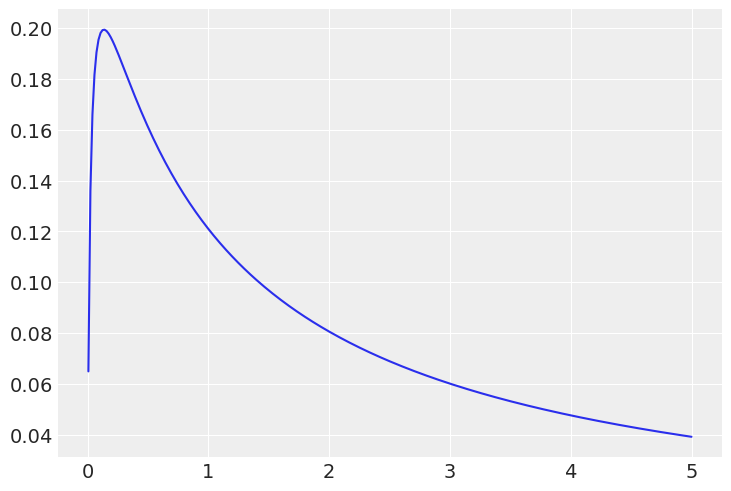

In [296]:
## For specifying what better priors could look like

from scipy.stats import lognorm
mu = 2
sigma = 2
xx = np.linspace(-0.01,5,300)

pdf = (np.exp(-(np.log(xx) - mu)**2 / (2 * sigma**2))
       / (xx * sigma * np.sqrt(2 * np.pi)))

plt.plot(xx,pdf)